In [1]:
from fwell.fwell import FWell
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cProfile, pstats

outer_bound = "nnnn"
top_bound = "imp"
bottom_bound = 'imp'
wtype = 'hor'
nseg = 20
nwells = 1
Xe = 1000
Ye = 1000
xw = Xe/2
yw = Ye/2
k = 10
h = 10
Lh = 500
rw = 0.1
xwds = [xw/(Lh/2)]
ywds = [yw/(Lh/2)]
xed = Xe/(Lh/2)
yed = Ye/(Lh/2)
hd = 2*h/Lh
rwd = rw/h
zwds = [0.5]
ct = 1e-5
mu = 1
B = 1
fi = 0.1
Q = 100
ts = np.logspace(-2,3, 100)
CT = 0.00036*k/(fi*mu*ct*(Lh/2)*(Lh/2))
CP = Q*18.42*mu*B/(k*h)
tds = ts*CT
fwell = FWell(outer_bound, top_bound, bottom_bound, wtype, nseg, nwells, xwds, ywds, xed=xed, yed=yed,
              zwds=zwds, hd=hd, rwd=rwd, attrs={'Fcd': 1e+6})

In [2]:
df = pd.read_csv('./saphire/hor_test_1.txt', delim_whitespace=True, skiprows = 11)
t_saph = np.array(df["(hr)"])
p_saph = np.array(df["(atm)"])
print(len(t_saph))

255


In [ ]:

u = 1/t_saph[-1]/CT
cProfile.runctx("fwell.lw.recalc(u)", globals(), locals(), "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

In [2]:
from fwell.ffunc.ffuncs import *

In [116]:
def IF3(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, fid1, fid2):
    if3 = IF31(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid1) +\
            IF32(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid)
    return if3

def IF31(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid):
    return ihF2E(zd, zwd, x1, x2, u, xd, xwd, xed, xed, hd, yd, ywd, yed, buf, fid)

def IF32(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid):
    if32 = IF321(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid+"_1") +\
        IF322(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid+"_2")
    return if32

def IF321(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid):
    MAXITER = 1000
    EPS = 1e-6
    coef = 0.5*xed/np.pi
    sum1, sum2, m = np.zeros_like(x1), np.zeros_like(x1), np.zeros_like(x1)
    for n in range(1, MAXITER):
        v1, v2, vm = IF321_n(n, u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid)
        sum1 += v1
        sum2 += v2
        m += vm
        if np.linalg.norm(v1) < EPS*np.linalg.norm(sum1) and np.linalg.norm(v2) < EPS*np.linalg.norm(sum2):
            break
    ans = sum1 + sum2
    ans += IF321_aux(u, zd, zwd, hd)*np.abs(0.5*m)
    return ans

def IF321_aux(u,zd, zwd, hd):
    MAXITER = 100000
    EPS = 1e-9
    sum_ = k0(np.sqrt(u*np.square((zd + zwd)*hd)))
    sum_ += k0(np.sqrt(u*np.square((zd - zwd)*hd)))
    for n in range(1, MAXITER):
        d = k0(np.sqrt(u*np.square((zd - zwd - 2*n)*hd))) + k0(np.sqrt(u*np.square((zd + zwd - 2*n)*hd)))
        d += k0(np.sqrt(u*np.square((zd - zwd + 2*n)*hd))) + k0(np.sqrt(u*np.square((zd + zwd + 2*n)*hd)))
        sum_ += d
        if np.linalg.norm(d) < EPS*np.linalg.norm(sum_):
            return 0.5*hd*sum_ - 0.5*np.pi/np.sqrt(u), sum_
    raise RuntimeWarning("IF321_aux did not converge")
    
def IF321_aux_(u,zd_, zwd_, hd):
    mshape = zd_.shape
    assert zwd_.shape == mshape
    zd = zd_[0,0]
    zwd = zwd_[0,0]
    sum_ = k0(np.sqrt(u*np.square((zd + zwd)*hd)))
    sum_ += k0(np.sqrt(u*np.square((zd - zwd)*hd)))
    for sz in [-1,1]:
        for sn in [-1,1]:
            vfunc = lambda n: k0(np.sqrt(u*np.square((zd + sz*zwd + sn*2*n)*hd)))
            sum_ += eulsum(vfunc)
    sum_ *= np.ones_like(zd_)
    return 0.5*hd*sum_ - 0.5*np.pi/np.sqrt(u), sum_
        
def IF321_n(n, u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid):
    MAXITER = 1000
    EPS = 1e-6
    PI = np.pi
    mult = np.cos(n*PI*zd)*np.cos(n*PI*zwd)
    sum1, sum2, m = np.zeros_like(x1), np.zeros_like(x1), np.zeros_like(x1)
    for b in [-1, 1]:
        v1, v2, vm = IF321_nk(0, n, b, u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid)
        sum1 += v1
        sum2 += v2
        m += vm
    for k_ in range(1, MAXITER):
        for k in [-k_, k_]:
            for b in [-1, 1]:
                v1, v2, vm = IF321_nk(k, n, b, u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid)
                sum1 += v1
                sum2 += v2
                m += vm
                if np.linalg.norm(v1) < EPS*np.linalg.norm(sum1) and np.linalg.norm(v2) < EPS*np.linalg.norm(sum2):
                    return mult*sum1, mult*sum2, m
    raise RuntimeError
    
def IF321_nk(k, n, b, u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid):
    # prep
    NDIGITS = 6
    mshape = x1.shape
    v_1 = np.zeros(mshape, dtype=np.double)
    v_2 = np.zeros(mshape, dtype=np.double)
    m1 = np.zeros(mshape, dtype=np.double)
    m2 = np.zeros(mshape, dtype=np.double)
    # calc
    dyd = yd - ywd
    inds_0 = np.isclose(dyd,0)
    inds_nnz = np.logical_not(inds_0)
    su = np.sqrt(u + np.square(n*np.pi/hd))
    if np.any(inds_0):
        t1 = xd[inds_0] + b*xwd[inds_0] - 2*k*xed - x2[inds_0]
        t2 = xd[inds_0] + b*xwd[inds_0] - 2*k*xed - x1[inds_0]
        mask1 = -1*(np.ones_like(t1) - 2*(t1>0))
        mask2 = -1*(np.ones_like(t1) - 2*(t2<0))
        t1 = np.round(np.abs(t1), decimals=NDIGITS).flatten()
        t2 = np.round(np.abs(t2), decimals=NDIGITS).flatten()
        nt = len(t1)
        t = np.append(t1,t2)
        ut, inv_t = np.unique(t, return_inverse=True)
        uv = ki1(ut*su)/su
        v = uv[inv_t]
        v1 = v[:nt]
        v2 = v[nt:]
        v_1[inds_0] = v1
        m1[inds_0] = mask1
        v_2[inds_0] = v2
        m2[inds_0] = mask2
    if np.any(inds_nnz):
        raise NotImplementedError
    return m1*v_1, m2*v_2, m1+m2  

def IF322():
    pass
    

In [72]:
def naive_sum(vfunc):
    EPS = 1e-9
    TINY = 1e-50
    s = 0
    d = 0
    for j in range(1, 100000):
        d = vfunc(j)
        s += vfunc(j)
        if np.abs(d) < EPS*np.abs(s):
            return s

In [73]:
%timeit -n10 -r10 eulsum(vfunc)
%timeit -n10 -r10 naive_sum(vfunc)

1.72 ms ± 78.1 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
130 ms ± 1.06 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [106]:
def eulsum(vfunc, j_0=False):
    # euler's algo for series summation 
    # vfunc - scalar-valued lambda-like function function
    # param: j_0 - whether to account for 0-th term in sum
    MAXTERM = 1000
    EPS = 1e-9
    TINY = 1e-50
    wksp = np.zeros(MAXTERM, dtype=np.float)
    nterm = 0
    sign = 1.
    ppsum = 0. #previous sum
    # account for 0-th term
    if j_0:
        psum = vfunc(0)
    else:
        psum = 0
    for j in range(1, MAXTERM):
        term = sign*wtrans(vfunc, j, verbose=0) # here we continue summation with n+1-th term
        sign *= -1.
        psum, wksp, nterm = eulsum_(psum, term, j, wksp, nterm) # but here we call eulsum_ with j-n jterm
        apsum = np.abs(psum)
        if np.abs(psum-ppsum) < EPS*apsum or apsum < TINY:
            return psum
        ppsum = psum.copy()
    raise RuntimeWarning("In eulsum: series did not converge in {} iterations".format(MAXTERM))
    
def eulsum_(psum, term, jterm, wksp, nterm):
    if jterm == 1:
        nterm = 1
        wksp[1] = term
        psum = 0.5*wksp[1]
    else:
        tmp = wksp[1]
        wksp[1] = term
        for j in range(1, nterm):
            dum = wksp[j+1]
            wksp[j+1] = 0.5*(wksp[j]+tmp)
            tmp=dum
            wksp[nterm+1] = 0.5*(wksp[nterm]+tmp)
            tmp=dum
        wksp[nterm+1] = 0.5*(wksp[nterm]+tmp)
        if (np.abs(wksp[nterm+1]) <= np.abs(wksp[nterm])):
            nterm += 1
            psum += (0.5*wksp[nterm])
        else:
            psum += wksp[nterm+1]
    return psum, wksp, nterm

def wtrans(vfunc, r, verbose=0):
    # returns VanWijngaarden - transformation terms w_r:
    # sum[v_r, r=1..oo] = sum[(-1)**(r-1)*w_r, r=1..oo]
    # vfunc - lambda-like function to eval with integer r
    # returns w_r
    MAXIT = 10000
    TINY = 1e-30
    EPS = 1e-12
    psum = vfunc(r)
    cpow = 2.
    for j in range(1,MAXIT):
        d = cpow*vfunc(cpow*r)
        psum += d
        cpow *= 2.
        ad = np.abs(d)
        if ad < np.abs(psum)*EPS or ad < TINY:
            if verbose==0:
                return psum
            elif verbose == 1:
                return psum, j
            elif verbose >= 2:
                return psum, j, d
    raise RuntimeError

In [126]:
u = 100
cProfile.runctx("IF321_aux(u,zd, zwd, hd)", globals(), locals(), "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

Wed Jun 26 13:10:24 2019    Profile.prof

         388 function calls in 0.018 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.018    0.018    0.018    0.018 <ipython-input-116-1485b40cfa39>:30(IF321_aux)
       48    0.000    0.000    0.000    0.000 linalg.py:2293(norm)
       48    0.000    0.000    0.000    0.000 {built-in method numpy.dot}
       48    0.000    0.000    0.000    0.000 {built-in method numpy.array}
       48    0.000    0.000    0.000    0.000 {method 'ravel' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.018    0.018 {built-in method builtins.exec}
       48    0.000    0.000    0.000    0.000 numeric.py:469(asarray)
       48    0.000    0.000    0.000    0.000 linalg.py:121(isComplexType)
       96    0.000    0.000    0.000    0.000 {built-in method builtins.issubclass}
        1    0.000    0.000    0.018    0.018 <string>:1(<module>)
        1    0.000    0.000    0.000

In [127]:
cProfile.run("IF321_aux_(u,zd, zwd, hd)", "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

Wed Jun 26 13:10:27 2019    Profile.prof

         543 function calls in 0.003 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      304    0.001    0.000    0.001    0.000 <ipython-input-116-1485b40cfa39>:52(<lambda>)
       76    0.001    0.000    0.002    0.000 <ipython-input-106-1ecbc868a558>:49(wtrans)
       76    0.000    0.000    0.000    0.000 <ipython-input-106-1ecbc868a558>:27(eulsum_)
        4    0.000    0.000    0.003    0.001 <ipython-input-106-1ecbc868a558>:1(eulsum)
        1    0.000    0.000    0.003    0.003 <ipython-input-116-1485b40cfa39>:43(IF321_aux_)
       72    0.000    0.000    0.000    0.000 {method 'copy' of 'numpy.generic' objects}
        4    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
        1    0.000    0.000    0.003    0.003 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method numpy.copyto}
        1    0.000    0.000    0.0

In [123]:
v_ = IF321_aux_(100,zd, zwd, hd)[-1]

In [124]:
v = IF321_aux(100,zd, zwd, hd)[-1]

In [125]:
v_, v

(array([[10.6190268, 10.6190268, 10.6190268, ..., 10.6190268, 10.6190268,
         10.6190268],
        [10.6190268, 10.6190268, 10.6190268, ..., 10.6190268, 10.6190268,
         10.6190268],
        [10.6190268, 10.6190268, 10.6190268, ..., 10.6190268, 10.6190268,
         10.6190268],
        ...,
        [10.6190268, 10.6190268, 10.6190268, ..., 10.6190268, 10.6190268,
         10.6190268],
        [10.6190268, 10.6190268, 10.6190268, ..., 10.6190268, 10.6190268,
         10.6190268],
        [10.6190268, 10.6190268, 10.6190268, ..., 10.6190268, 10.6190268,
         10.6190268]]),
 array([[10.61902679, 10.61902679, 10.61902679, ..., 10.61902679,
         10.61902679, 10.61902679],
        [10.61902679, 10.61902679, 10.61902679, ..., 10.61902679,
         10.61902679, 10.61902679],
        [10.61902679, 10.61902679, 10.61902679, ..., 10.61902679,
         10.61902679, 10.61902679],
        ...,
        [10.61902679, 10.61902679, 10.61902679, ..., 10.61902679,
         10.61902679, 10

In [5]:
zd, zwd, yd, ywd, hd, xd, xwd = fwell.lw.zd, fwell.lw.zwd, fwell.lw.yd, fwell.lw.ywd, fwell.lw.hd, fwell.lw.xd, fwell.lw.xwd
x1, x2 = fwell.lw.x1, fwell.lw.x2

In [8]:
vals = IF321(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, [], "")

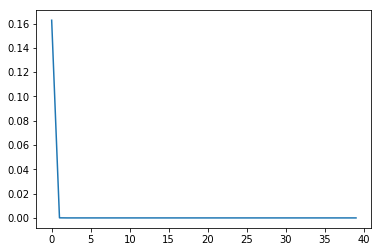

In [9]:
plt.plot(vals[0,:])

In [10]:
n = 12
c1, c2, m = IF321_n(n, u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, [], "")

In [12]:
np.abs(0.5*m)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [13]:
ki1?

In [18]:
x = np.random.random((10,10))

In [19]:
n = np.arange(10)

In [30]:
u = 0.01
su = np.sqrt(u+n**2).reshape(-1,1)

In [32]:
(x*su).shape

(10, 10)

In [37]:
(x[np.newaxis]*su).shape

(1, 10, 10)

In [38]:
su.shape

(10, 1)

In [43]:
np.tile(x,(1,1,3)).shape

(1, 10, 30)

In [46]:
x.shape

(10, 10)

In [53]:
np.broadcast_to(x, (3,10,10))*(np.array([1,2,3]).reshape(3,1))

ValueError: operands could not be broadcast together with shapes (3,10,10) (3,1) 

In [54]:
np.array([1,2,3]).reshape(3,1)

array([[1],
       [2],
       [3]])

In [77]:
xx = np.broadcast_to(x, (3,*x.shape))

In [75]:
xx.shape

(3, 10, 10)

In [70]:
a = np.arange(3).reshape(3,1,1)

In [72]:
a*xx

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.    

In [81]:
z_mi = np.broadcast_to(zd-zwd, (100, *(zd.shape)))
n = np.arange(1,101).reshape(100,1,1)
(z_mi - 2*n)

array([[[  -1.99,   -1.99,   -1.99, ...,   -1.99,   -1.99,   -1.99],
        [  -1.99,   -1.99,   -1.99, ...,   -1.99,   -1.99,   -1.99],
        [  -1.99,   -1.99,   -1.99, ...,   -1.99,   -1.99,   -1.99],
        ...,
        [  -1.99,   -1.99,   -1.99, ...,   -1.99,   -1.99,   -1.99],
        [  -1.99,   -1.99,   -1.99, ...,   -1.99,   -1.99,   -1.99],
        [  -1.99,   -1.99,   -1.99, ...,   -1.99,   -1.99,   -1.99]],

       [[  -3.99,   -3.99,   -3.99, ...,   -3.99,   -3.99,   -3.99],
        [  -3.99,   -3.99,   -3.99, ...,   -3.99,   -3.99,   -3.99],
        [  -3.99,   -3.99,   -3.99, ...,   -3.99,   -3.99,   -3.99],
        ...,
        [  -3.99,   -3.99,   -3.99, ...,   -3.99,   -3.99,   -3.99],
        [  -3.99,   -3.99,   -3.99, ...,   -3.99,   -3.99,   -3.99],
        [  -3.99,   -3.99,   -3.99, ...,   -3.99,   -3.99,   -3.99]],

       [[  -5.99,   -5.99,   -5.99, ...,   -5.99,   -5.99,   -5.99],
        [  -5.99,   -5.99,   -5.99, ...,   -5.99,   -5.99,   -5.99],
    

(100, 40, 40)